# RL and Advanced DL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения


1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


### Tic Tac Toe environment, за основу взята среда из семинара

In [88]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict


EMPTY = 0
CROSSES_TURN = 1
NOUGHTS_TURN = 2

DRAW_REWARD = 0
BAD_MOVE_REWARD = -10
CROSSES_WIN_REWARD = CROSSES_TURN
NOUGHTS_WIN_REWARD = NOUGHTS_TURN


class TicTacToeEnv(gym.Env):

    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.reset()
    
    
    # методы требующиеся для интерфейса env
    
    def reset(self):
        self.board = np.full((self.n_rows, self.n_cols), EMPTY, dtype=int)
        self.allowed_actions = self._allowed_actions()
        self.board_hash = self._board_hash()
        self.turn = CROSSES_TURN
    
    
    def step(self, action):
        reward = self._player_move(action) if self.board[action[0], action[1]] == EMPTY else BAD_MOVE_REWARD
        reward, done = (0 if reward is None else reward), (reward is not None)
        return self.state(), reward, done, {}
    
    
    def state(self):
        return (self.board_hash, self.allowed_actions, self.turn)
    
    
    # вспомогательные методы    
    
    def _other_player_turn(self):
        return CROSSES_TURN if self.turn == NOUGHTS_TURN else NOUGHTS_TURN

    
    def _board_hash(self):
        return ''.join([str(x) for x in self.board.reshape(self.n_rows * self.n_cols)])

    
    def _allowed_actions(self):
        free_positions = np.where(self.board == EMPTY)
        return np.array([ (i, j) for i, j in zip(free_positions[0], free_positions[1]) ])
    
    
    def _winner(self):
        return CROSSES_WIN_REWARD if self.turn == CROSSES_TURN else NOUGHTS_WIN_REWARD
    
    
    def _player_move(self, action):
        self.board[action[0], action[1]] = self.turn
        self.board_hash = self._board_hash()
        self.allowed_actions = self._allowed_actions()
        self.turn = self._other_player_turn()
        return self._reward()

    
    def _reward(self):
        '''
        check if current turn wins the game, returns reward or None if not done yet
        '''
        turn_positions = np.where(self.board == self.turn)
        
        for i, j in zip(turn_positions[0], turn_positions[1]):
            # check rows
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == self.turn):
                    return self._winner()
            # check cols
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == self.turn):
                    return self._winner()
            # check primary diags
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == self.turn for k in range(self.n_win) ])):
                    return self._winner()
            # check secondary diags
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == self.turn for k in range(self.n_win) ])):
                    return self._winner()

        if len(self.allowed_actions) == 0:
            return DRAW_REWARD

        # not done yet
        return None

### Стратегии: Random и EpsGreedy

In [77]:
def get_pi(pi_crosses, pi_noughts, turn):
    return pi_crosses if turn == CROSSES_TURN else pi_noughts


class BasePolicy:
    def __init__(self, turn):
        self.turn = turn
    
    def check_win(self, reward):
        if reward == CROSSES_WIN_REWARD:
            return 1 if self.turn == CROSSES_TURN else -1
        if reward == NOUGHTS_WIN_REWARD:
            return 1 if self.turn == NOUGHTS_TURN else -1
        return 0 # draw

    
class RandomPolicy(BasePolicy):
    
    def select_action(self, state):
        _, allowed_actions, _ = state
        action_idx = np.random.randint(len(allowed_actions))
        return action_idx

    
class EpsGreedyPolicy(BasePolicy):
    def __init__(self, turn, eps):
        self.Q = {}
        self.turn = turn
        self.eps = eps

    def select_action(self, state):
        board_hash, allowed_actions, _ = state
        
        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(allowed_actions))
        
        if random.random() >= self.eps:
            return np.argmax(self.Q[board_hash])
        else:
            return np.random.randint(len(allowed_actions))

### Валидация обученной стратегии: проверяем winrate относительно случайной

In [105]:
def run_eval_episode(env, policies):
    
    env.reset()
    state = env.state()
    _, allowed_actions, turn = state

    done = False
    while not done:
        action_idx = policies[turn].select_action(state)
        action = allowed_actions[action_idx]
        state, reward, done, _ = env.step(action)
        _, allowed_actions, turn = state

    return reward

In [109]:
def eval_policy(env, pi, episodes, verbose=False):
    """
    eval policy pi vs RandomPolicy,
    returns winrate, looserate, drawrate
    """
    policies = dict()
    policies[CROSSES_TURN] = pi if pi.turn == CROSSES_TURN else RandomPolicy(turn=NOUGHTS_TURN)
    policies[NOUGHTS_TURN] = pi if pi.turn == NOUGHTS_TURN else RandomPolicy(turn=CROSSES_TURN)
    
    wins = 0
    looses = 0
    draws = 0

    for _ in tqdm(range(episodes), disable = not verbose):
        reward = run_eval_episode(env, policies)
        is_win = pi.check_win(reward)
        wins += int(is_win == 1)
        looses += int(is_win == -1)
        draws += int(is_win == 0)

    return wins / episodes, looses / episodes, draws / episodes

In [129]:
def plot_history(history, player, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title(f'Average rates during {player} training', fontsize=fontsize)
    plt.xlabel('Step', fontsize=fontsize)
    plt.ylabel('Average rate', fontsize=fontsize)
    history = history[player]
    x = [s for s, _, _, _ in history]
    wr = [s for _, s, _, _ in history]
    lr = [s for _, _, s, _ in history]
    dr = [s for _, _, _, s in history]
    plt.plot(x, wr, label="winrate")
    plt.plot(x, lr, label="looserate")
    plt.plot(x, dr, label="drawrate")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [130]:
# sanity checks для random policy

ENV = TicTacToeEnv(n_rows=3, n_cols=3, n_win=3)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), 10000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN), 10000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToeEnv(n_rows=4, n_cols=4, n_win=4)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), 10000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN), 10000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToeEnv(n_rows=5, n_cols=5, n_win=5)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), 10000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN), 10000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

CrossRandomPolicy on 3x3: winrate=0.3576, looserate=0.286, drawrate=0.3564
NoughtsRandomPolicy on 3x3: winrate=0.2859, looserate=0.3578, drawrate=0.3563

CrossRandomPolicy on 4x4: winrate=0.3112, looserate=0.1671, drawrate=0.5217
NoughtsRandomPolicy on 4x4: winrate=0.1612, looserate=0.3156, drawrate=0.5232

CrossRandomPolicy on 5x5: winrate=0.1638, looserate=0.1569, drawrate=0.6793
NoughtsRandomPolicy on 5x5: winrate=0.16, looserate=0.1614, drawrate=0.6786



### Обучаем EpsGreedy стратегию с помощью Q-learning

In [117]:
def q_learning_episode(env, policies, alpha, gamma):

    env.reset()
    state = env.state()
    board_hash, allowed_actions, turn = state
    prev_board_hash, prev_action_idx = None, None

    done = False
    while not done:
        
        # update curr turn policy
        pi = policies[turn]
        action_idx = pi.select_action(state)
        action = allowed_actions[action_idx]
        state, reward, done, _ = env.step(action)
        if pi.check_win(reward) == 1:
            pi.Q[board_hash][action_idx] = 1
        policies[turn] = pi

        # update opposite policy
        next_board_hash, next_allowed_actions, next_turn = state
        pi = policies[next_turn]
        if prev_board_hash is not None:
            gamma_term = gamma * np.max(pi.Q[next_board_hash]) if next_board_hash in pi.Q else 0
            pi.Q[prev_board_hash][prev_action_idx] += alpha * (
                - reward + gamma_term - pi.Q[prev_board_hash][prev_action_idx]
            )
        policies[next_turn] = pi

        prev_board_hash, prev_action_idx = board_hash, action_idx
        board_hash, allowed_actions, turn = state

    return policies

In [124]:
def q_learning(env, pi_crosses, pi_noughts,
               episodes = 10000, eval_episodes = 1000, eval_every = 1000,
               alpha = 0.015, gamma = 1.0, fit=True):
    
    policies = dict()
    policies[CROSSES_TURN] = pi_crosses
    policies[NOUGHTS_TURN] = pi_noughts
    
    hist = defaultdict(list)
    for e in tqdm(range(episodes)):
        
        if fit:
            policies = q_learning_episode(env, policies, alpha, gamma)

        if (e + 1) % eval_every == 0:
            step = e + 1
            wr, lr, dr = eval_policy(env, policies[CROSSES_TURN], eval_episodes)
            hist['crosses'].append((step, wr, lr, dr))
            wr, lr, dr = eval_policy(env, policies[NOUGHTS_TURN], eval_episodes)
            hist['noughts'].append((step, wr, lr, dr))

    return hist

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1388.61it/s]


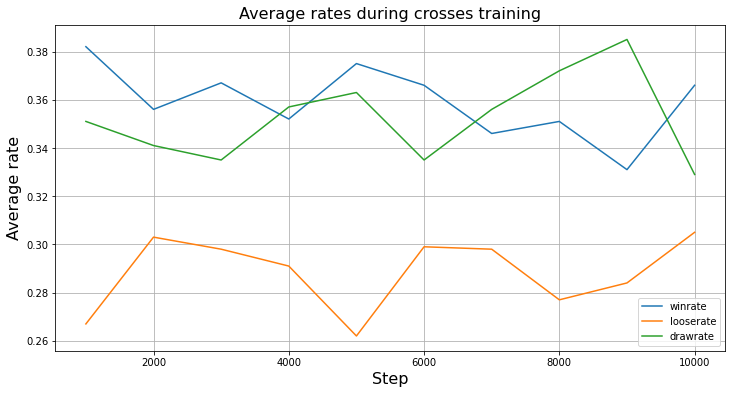

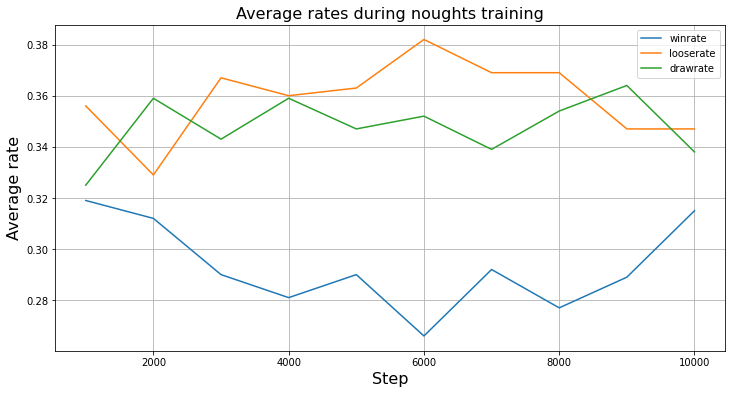

In [128]:
hist = q_learning(
    TicTacToeEnv(n_rows=3, n_cols=3, n_win=3),
    pi_crosses=RandomPolicy(turn=CROSSES_TURN),
    pi_noughts=RandomPolicy(turn=NOUGHTS_TURN),
    fit=False
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')